In [1]:
# ! pip install -q kaggle

In [2]:
# from google.colab import files
# files.upload()

In [3]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install pytorch-lightning
!pip install transformers
# !pip install vncorenlp

     |████████████████████████████████| 526 kB 7.6 MB/s 
     |████████████████████████████████| 332 kB 55.5 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 829 kB 55.0 MB/s 
     |████████████████████████████████| 133 kB 61.2 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 192 kB 75.9 MB/s 
     |████████████████████████████████| 271 kB 61.3 MB/s 
     |████████████████████████████████| 160 kB 74.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8a587433eb111f71f37506a22cd5864f4670eef7cde1d5531b57616813adfab3
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [7]:
# !kaggle datasets download -d gianmarco96/upmcfood101

In [8]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import re
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import os
import glob


In [9]:
!ls
data_zip_file = './upmcfood101.zip'
train_csv = 'texts/train_titles.csv'
test_csv = 'texts/test_titles.csv'

my_checkpoint_multi_20.pth.tar	RNN  upmcfood101.zip  UPMC-Multimodal.ipynb


# Data preprocessing

## Image data

In [10]:
data_zip = zipfile.ZipFile(data_zip_file)

In [11]:
data_zip.namelist()[:10]

['images/test/apple_pie/apple_pie_1.jpg',
 'images/test/apple_pie/apple_pie_10.jpg',
 'images/test/apple_pie/apple_pie_103.jpg',
 'images/test/apple_pie/apple_pie_105.jpg',
 'images/test/apple_pie/apple_pie_107.jpg',
 'images/test/apple_pie/apple_pie_119.jpg',
 'images/test/apple_pie/apple_pie_12.jpg',
 'images/test/apple_pie/apple_pie_123.jpg',
 'images/test/apple_pie/apple_pie_124.jpg',
 'images/test/apple_pie/apple_pie_132.jpg']

images/test/apple_pie/apple_pie_10.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300 at 0x7FCA66DB2790>
(300, 300, 3)


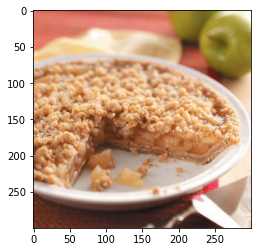

In [12]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [13]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [14]:
# Train data
colnames=['image_path', 'text', 'food']
train_df = pd.read_csv(data_zip.open(train_csv), names=colnames)
print(train_df.shape)
train_df.head()

(67972, 3)


image_path  ...       food
0  apple_pie_851.jpg  ...  apple_pie
1  apple_pie_140.jpg  ...  apple_pie
2  apple_pie_858.jpg  ...  apple_pie
3  apple_pie_449.jpg  ...  apple_pie
4  apple_pie_695.jpg  ...  apple_pie

[5 rows x 3 columns]

In [15]:
test_df = pd.read_csv(data_zip.open(test_csv), names=colnames)
test_df.head()

image_path  ...       food
0  apple_pie_175.jpg  ...  apple_pie
1  apple_pie_107.jpg  ...  apple_pie
2  apple_pie_554.jpg  ...  apple_pie
3  apple_pie_445.jpg  ...  apple_pie
4   apple_pie_12.jpg  ...  apple_pie

[5 rows x 3 columns]

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67972 entries, 0 to 67971
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  67972 non-null  object
 1   text        67972 non-null  object
 2   food        67972 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [17]:
process_path = [p.split('/')[-1] for p in data_zip.namelist()]

In [18]:
## Check non img path
def check_non_exist_img(df):
  for i in list(df.iloc[:,0]):
    if i in process_path:
      pass
    else:
      print('nulll')
      break;
  
  return 'full_img'
print(check_non_exist_img(test_df))
print(check_non_exist_img(train_df))

full_img
full_img


In [19]:
# process img path
def preprocess_imgpath(new_df):
  new_df['image_path'] = new_df.apply(lambda x: x['food']+'/'+x['image_path'], axis = 1)
  return new_df
train_df = preprocess_imgpath(train_df)
train_df.head()

image_path  ...       food
0  apple_pie/apple_pie_851.jpg  ...  apple_pie
1  apple_pie/apple_pie_140.jpg  ...  apple_pie
2  apple_pie/apple_pie_858.jpg  ...  apple_pie
3  apple_pie/apple_pie_449.jpg  ...  apple_pie
4  apple_pie/apple_pie_695.jpg  ...  apple_pie

[5 rows x 3 columns]

In [20]:
test_df = preprocess_imgpath(test_df)
test_df.head()

image_path  ...       food
0  apple_pie/apple_pie_175.jpg  ...  apple_pie
1  apple_pie/apple_pie_107.jpg  ...  apple_pie
2  apple_pie/apple_pie_554.jpg  ...  apple_pie
3  apple_pie/apple_pie_445.jpg  ...  apple_pie
4   apple_pie/apple_pie_12.jpg  ...  apple_pie

[5 rows x 3 columns]

In [21]:
Classes = train_df.food.unique()
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(Classes)

train_df['process_label'] = le.transform(train_df['food'])
train_df.head()

image_path  ... process_label
0  apple_pie/apple_pie_851.jpg  ...             0
1  apple_pie/apple_pie_140.jpg  ...             0
2  apple_pie/apple_pie_858.jpg  ...             0
3  apple_pie/apple_pie_449.jpg  ...             0
4  apple_pie/apple_pie_695.jpg  ...             0

[5 rows x 4 columns]

In [22]:
test_df['process_label'] = le.transform(test_df['food'])

In [23]:
def preprocess_text(sentence):
    # Removing html tags
    sentence = re.sub(r'<[^>]+>', '', sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Lower sentence
    sentence = sentence.lower()
    return sentence

train_df['text'] = train_df.apply(lambda x: preprocess_text(x['text']), axis = 1)

In [24]:
test_df['text'] = test_df.apply(lambda x: preprocess_text(x['text']), axis = 1)

In [25]:
train_df.head()

image_path  ... process_label
0  apple_pie/apple_pie_851.jpg  ...             0
1  apple_pie/apple_pie_140.jpg  ...             0
2  apple_pie/apple_pie_858.jpg  ...             0
3  apple_pie/apple_pie_449.jpg  ...             0
4  apple_pie/apple_pie_695.jpg  ...             0

[5 rows x 4 columns]

In [26]:
test_df.head()

image_path  ... process_label
0  apple_pie/apple_pie_175.jpg  ...             0
1  apple_pie/apple_pie_107.jpg  ...             0
2  apple_pie/apple_pie_554.jpg  ...             0
3  apple_pie/apple_pie_445.jpg  ...             0
4   apple_pie/apple_pie_12.jpg  ...             0

[5 rows x 4 columns]

# Load BPE, Vocab of PhoBERT and DataGen

In [27]:
from transformers import BertTokenizer, BertModel

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
text = "Replace me by any text you'd like. I can play"
text2 = "hello world"
encoded_input = tokenizer([text, text2],max_length=5,padding='max_length', truncation=True, return_tensors='pt')
encoded_input

{'input_ids': tensor([[ 101, 5672, 2033, 2011,  102],
        [ 101, 7592, 2088,  102,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0]])}

In [30]:
tokenizer.decode(encoded_input['input_ids'][0])

'[CLS] replace me by [SEP]'

In [31]:
MAX_LEN = 20

In [69]:
trans = T.ToTensor()

class SentimentData(Dataset):
  def __init__(self, data, transform = None, additional_img_path = None):
    self.df = data.reset_index()
    self.transform = transform
    self.additional_img_path = additional_img_path
  def __len__(self):
    return len(self.df)  
  def __getitem__(self,idx):
    # print(idx)
    text = self.df["text"][idx]
    # print(self.additional_img_path+self.df['image_path'][idx])
    img = Image.open(data_zip.open(self.additional_img_path+self.df['image_path'][idx]))
    if self.transform is not None:
      img = self.transform(img)

    # print(text.shape)
    label = self.df["process_label"][idx]

    return (text, img, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, train_df, test_df, batch_size: int = 80, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.train_df = train_df
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = test_df

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.train_df, test_size = self.test_size, random_state = 42)

  def setup(self, stage = None):
      train_transform = T.Compose([
        T.Resize([299, 299]),
        T.ToTensor(),
        # T.RandomHorizontalFlip(), T.RandomRotation(10),
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform, 'images/train/')
      self.val = SentimentData(self.val_data, val_transform, 'images/train/')
      self.test = SentimentData(self.test_data, test_transform, 'images/test/')


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size)

  def test_dataloader(self, shuffle = False):
      return DataLoader(self.test, batch_size=self.batch_size, shuffle=shuffle)

  

In [33]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(train_df, test_df)
  dm.prepare_data()
  dm.setup()
  for step,(item1,item3,item2) in enumerate(dm.train_dataloader()):
    # print(step)
    print(item1)
    print(item3.shape)
    print(item2)
    if step > 1: break

('quick macaroni and cheese recipe simply recipes', 'filet mignon red wine vinegar recipes yummly', 'chicken quesadillas baked or grilled spend with pennies', 'recipe eggs benedict riceandbread', 'vegetarian paella recipe vegetarian times', 'grilled salmon packets recipe kraft recipes', ' shawna food and recipe blog avocado and mushroom miso soup ', 'takoyaki shizuoka gourmet', 'secret recipe menu singapore', 'recipe bacon poutine riceandbread', 'how to make french fries eatocracy cnn com blogs', 'oven baked garlic fries recipe popsugar food', 'hidden valley lunch break for kids fundraiser easy ranch chicken quesadillas recipe the shopping mama', 'slow cooker spaghetti bolognese spend with pennies', 'cornmeal strawberry shortcake with lemon curd whipped cream driscoll s', 'healthy vegan recipes', 'paleo appetizers and snacks recipes', 'everyday food with sarah carey videos how tos and step by step videos martha stewart', 'rosemary roasted potato wedges recipe myrecipes com', 'shrimp am

# BERT

In [34]:
# model = BertModel.from_pretrained("bert-base-uncased")

In [35]:
class Bert_Lstm(nn.Module):
  def __init__(self):
    super(Bert_Lstm, self).__init__()
    self.BERT = BertModel.from_pretrained("bert-base-uncased")
    self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
  def forward(self, texts):
    bert_out = self.BERT(**texts)
    bert_out = bert_out['last_hidden_state']
    out, _ = self.lstm(bert_out)
    feature_extract = out[:,-1,:].contiguous()

    return feature_extract

In [36]:
# batch_dat = next(iter(dm.train_dataloader()))[0]
# dat = tokenizer(batch_dat,max_length=20,padding='max_length', truncation=True, return_tensors='pt')
# dat
# encoded_input = tokenizer(dat, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt')
# output = model(**dat)
# output['last_hidden_state'].shape

In [37]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# oooo = pho_test(dat)
# print(oooo.shape)
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [38]:
from torchvision.models import inception_v3

In [39]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

In [40]:
# model = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)

In [41]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
    self.flat = nn.Linear(2048, 128)

  def forward(self, image):
    feature = self.incept_sequen(image)
    # print(feature.shape)
    out = self.avgpool(feature)
    # print(out.shape)
    out = out.contiguous().view(-1, 2048)
    # out = 
    img_fea = self.flat(out)

    return img_fea


In [42]:
# a = torch.rand(16,3,299,299)
# a[0].shape

In [43]:
# mod = Inception()
# mod

In [44]:
# out = mod(a)
# print(out.shape)

In [45]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)), pooling='avg')
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [46]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [47]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [48]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=2, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

class Concatmodal(nn.Module):
  def __init__(self):
    super(Concatmodal,self).__init__()
    # self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,101)
    
  def forward(self, image, texts, labels=None):
    inputs = tokenizer(texts, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt')

    for key in inputs:
        inputs[key] = inputs[key].to(device)
    image = image.to(device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out

Computation device: cuda



In [50]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100

  counter = 0
  # total = 0

  model.train()

  for i, (texts, images, labels) in enumerate(dm.train_dataloader()):
      counter += 1
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, texts)

      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
      # _, preds = torch.max(outputs.data, 1)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
  train_loss = train_running_loss / counter

  return train_loss

In [51]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = torch.tensor([], device=device)
  val_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        val_running_loss += loss.item()
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)
    
  val_preds = val_preds.cpu().numpy()
  val_labels = val_labels.cpu().numpy()

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  val_ac = accuracy_score(val_labels, val_preds)

  return val_loss, val_ac


In [52]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test',classification_report(test_labels, test_preds))
  print('test_ac',accuracy_score(test_labels, test_preds))
  # test_loss = test_running_loss / counter



In [53]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [54]:
# testing(mo, dm)

In [55]:
def save_checkpoint(state, filename='my_checkpoint_multi_20.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [56]:
%ls

my_checkpoint_multi_20.pth.tar  RNN/  upmcfood101.zip  UPMC-Multimodal.ipynb


In [54]:
## Freeze
def freeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
  return model

## Unfreeze
def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
  return model
# model = freeze(model)

In [ ]:
from torch.optim import lr_scheduler

#define model
model = Concatmodal()
# model = freeze(model)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# # define hyper
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
#training
epochs = 15
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()

min_loss = np.Inf
for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      # filename = 'model{loss}-{epoch}.pth.tar'
      # filename = filename.format(loss= min_loss, epoch= epoch)
      save_checkpoint(checkpoint)

testing(model, dm)


In [89]:
epochs = 7
min_loss = np.Inf
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

lr_scheduler = LRScheduler(optimizer)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping()

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      # filename = 'model{loss}-{epoch}.pth.tar'
      # filename = filename.format(loss= min_loss, epoch= epoch)
      save_checkpoint(checkpoint)

testing(model, dm)

134,130,605 total parameters.
134,130,605 training parameters.
Epoch 0 of 7
Epoch 0 Step 99 ave_loss 0.0132
Epoch 0 Step 199 ave_loss 0.0194
Epoch 0 Step 299 ave_loss 0.0158
Epoch 0 Step 399 ave_loss 0.0164
Epoch 0 Step 499 ave_loss 0.0189
Epoch 0 Step 599 ave_loss 0.0185
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       145
         1.0       0.96      0.96      0.96       137
         2.0       0.95      0.92      0.93       134
         3.0       0.77      0.87      0.82       120
         4.0       0.72      0.74      0.73       135
         5.0       0.90      0.92      0.91       129
         6.0       0.98      0.90      0.94       133
         7.0       0.97      0.93      0.95       138
         8.0       0.96      0.92      0.94       145
         9.0       0.92      0.90      0.91       122
        10.0       0.89      0.92      0.91       136
        11.0       0.97      0.97      0.97       127
        12.0       0.96 

## Load to resume

In [81]:
PATH = "/content/drive/MyDrive/Colab Notebooks/my_checkpoint_multi_20.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Concatmodal()
# model.load_state_dict(checkpoint['state_dict'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [82]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [83]:
print(next(model.parameters()).device)

cpu


In [84]:
print(device)

cuda


In [87]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(checkpoint['optimizer'])
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

134,130,605 total parameters.
134,130,605 training parameters.


In [75]:
import gc

# del dm1
gc.collect()

75257

480


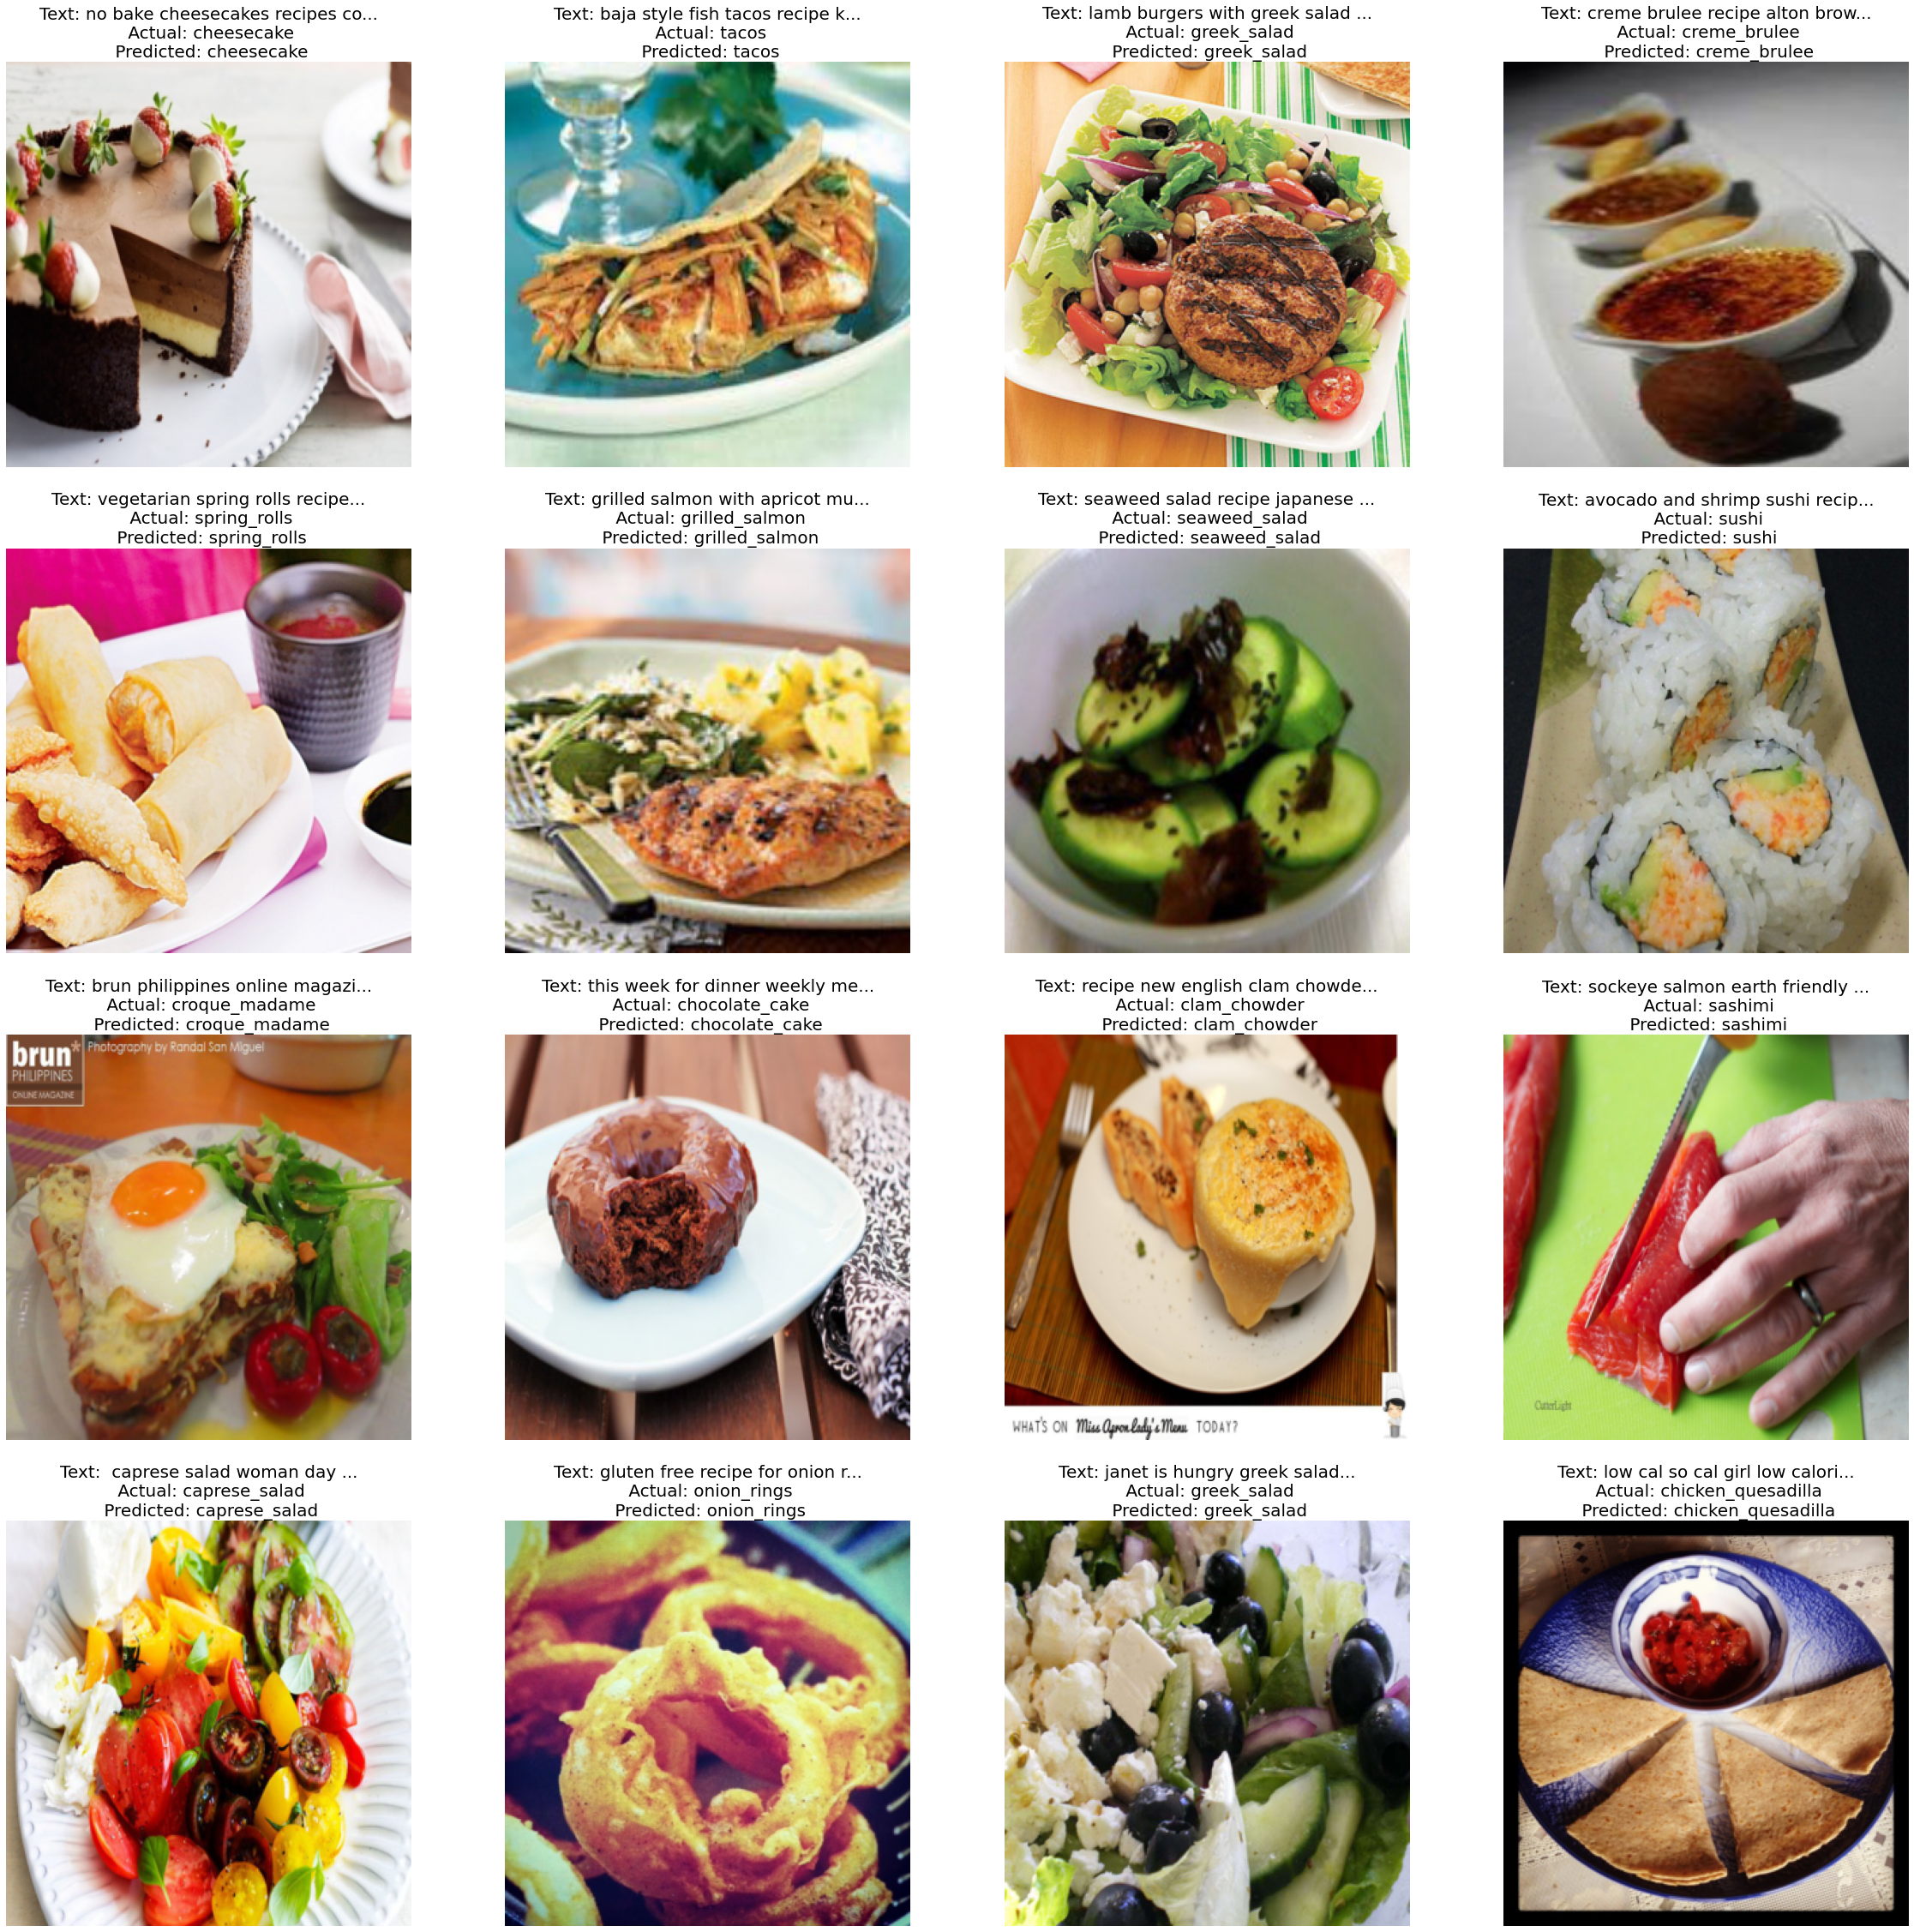

In [71]:
import cv2
model.to(device)
dm1 = SentimentDataModule(train_df, test_df)
dm1.prepare_data()
dm1.setup()
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []
  iter = 0

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm1.test_dataloader(True)):
        iter += 1
        labels = labels.to(device)

        outputs = model(images, texts)
        # print(outputs.device)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for im in images:
          test_img.append(im) 
        
        if iter > 5:
          iter = 0
          break;

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()

  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):
        label = le.inverse_transform([int(label)])[0]
        actual_label = le.inverse_transform([int(actual_label)])[0]
        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label), fontsize=20)
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_false_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


